# Práctica 3 - Ejercicio 2

Asignatura: Programación para la Inteligencia Artificial

Alumno:Francisco Javier Pérez Cazorla

Uno de los primeros modelos propuestos para la generación de datos usando Aprendizaje profundo fue el *Variational Autoencoder* (VAE).

Un VAE es una red autocodificadora que durante su entrenamiento, en lugar de codificar a un espacio latente de manera determinista (cada ejemplo tiene asociada una codificación), asocia distribuciones gaussianas que se muestrean para obtener una codificación que seguidamente se decodifica. Por tanto, el proceso queda como sigue:

$$\mu, \sigma^2 = e_{\theta_1}(x)$$

$$z \sim \mathcal{N}(\mu, \sigma^2) $$

$$y = d_{\theta_{2}} (z)$$

Para realizar el entrenamiento como cualquier red autocodificadora, se incluye una función de pérdida de reconstrucción:

$$L_{r}(x,y)$$

Pero además se añade una función de pérdida con el objetivo de regularizar las distribuciones gaussianas que pueden aprenderse. Para esto se usa la Divergencia de Kullback-Leibler, que mide el grado de disimilitud entre una distribución de probabilidad $Q$ respecto a una distribución de probabilidad $P$:

$$D_{KL}(P,Q) = \sum_{x \in X} P(x) log (\frac{P(x)}{Q(x)})$$

La divergencia KL se utiliza para penalizar que las distribuciones gaussianas se alejen de la distribución gaussiana de media 0 y varianza 1 ($\mathcal{N}(0, 1)$). Teniendo eso en cuenta, su formulación se puede simplificar a:

$$L_{KL}(\mu, \sigma)= \sum_{i=0}^n -\frac{1}{2}(1+log (\sigma_i^2) - \mu_i^2 - \sigma_i^2)$$

Siendo la función de pérdida que se usa durante el entrenamiento:

$$L = L_{r} + \alpha L_{KL}$$

con $\alpha$ un hiperparámetro que controla cuánto peso tiene la divergencia de Kullback-Leibler respecto a la pérdida de reconstrucción.

Tras implementar el VAE, se entrenará para los datos de  Fashion-MNIST con un espacio latente de 8 dimensiones (el vector $\mu$ y el que representa sus respectivas varianzas tienen 8 dimensiones cada uno). Una vez entrenado y comprobado debidamente que funciona, se mostrará las componentes del vector $\mu$ del conjunto de test en el espacio latente usando gráficas bidimensionales que indican la clase de cada ejemplo como en el Ejercicio 1.

Después, se extraerá el vector prototípico para cada clase en el conjunto de test (la media de los vectores $\mu$ para cada clase) y se mostrarán las imágenes generadas por el decodificador a partir de las codificaciones interpoladas entre los vectores prototípicos de dos clases cualesquiera.

Notas:
 * Para realizar el muestreo $z$ permitiendo la retropropagación del error se usa el "truco de reparametrización": no muestrear directamente la distribución gaussiana obtenida (eso rompería el grafo de cómputo), sino la distribución gaussiana $\hat{z} \sim \mathcal{N}(0, 1)$ y aprovechar la propiedad de las gaussianas para convertir el muestreo de una distribución gaussiana en el de otra para que (una vez simplificado aprovechando que se muestrea la normal) quede  $z =  \hat{z} \sigma + \mu$.
 * Es más fácil (y equivalente) que el encoder genere el logaritmo de la varianza en lugar de la varianza. Así se evita la posibilidad de intentar computar un $log(0)$. Obviamente hay que ajustar las fórmulas que se implementan de manera acorde.
 * Aunque PyTorch implementa diversas funciones para calcular la divergencia KL, ninguna está directamente pensada para este uso y su aplicación no es directa, así que es más fácil simplemente implementarla. Hay que recordar usar los operadores de PyTorch para que se genere el grafo de cómputo sin problema y que la pérdida de un lote debe ser la media de las pérdidas de los ejemplos que lo forman.
 * El valor $\alpha$ para conseguir un entrenamiento apropiado puede ser muy bajo según el conjunto de datos al que se aplique (incluso menos de 0.01).

### 1. Configuración e Inicialización
Importamos las librerías y definimos la configuración global (`SYS_CONFIG`) para evitar números mágicos. Usamos `KL_ALPHA = 0.0005` ya que para FashionMNIST se requiere un peso muy bajo en la divergencia KL para obtener buenas reconstrucciones.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import copy
from sklearn.manifold import TSNE

# Configuración Visual (Estilo 'Dark' para contraste)
plt.style.use('dark_background')
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['grid.color'] = '#ffffff'

# --- HIPERPARÁMETROS DEL SISTEMA (VAE) ---
SYS_CONFIG = {
    'BATCH_SIZE': 128,          # Tamaño de lote
    'LEARNING_RATE': 1e-3,      # Tasa de aprendizaje
    'EPOCHS': 150,              # Épocas máximas (con Early Stopping)
    'PATIENCE': 10,             # Paciencia para parar si no mejora
    'LATENT_DIM': 8,            # Dimensión del espacio latente (Requerido: 8)
    'KL_ALPHA': 0.0005,         # Peso de la pérdida KL (Debe ser bajo para F-MNIST)
    'SEED': 42
}

# Detección de Hardware
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SYS_CONFIG['SEED'])

print(f"╔{'═'*40}╗")
print(f"║ SISTEMA VAE INICIALIZADO               ║")
print(f"╠{'═'*40}╣")
print(f"║ Dispositivo     : {str(DEVICE).upper():<20} ║")
print(f"║ Dim. Latente    : {SYS_CONFIG['LATENT_DIM']:<20} ║")
print(f"║ Alpha (KL)      : {SYS_CONFIG['KL_ALPHA']:<20} ║")
print(f"╚{'═'*40}╝")

╔════════════════════════════════════════╗
║ SISTEMA VAE INICIALIZADO               ║
╠════════════════════════════════════════╣
║ Dispositivo     : CUDA                 ║
║ Dim. Latente    : 8                    ║
║ Alpha (KL)      : 0.0005               ║
╚════════════════════════════════════════╝


### 2. Carga de Datos Optimizada (FastGPULoader)
Implementamos la clase `FastGPULoader` para cargar el dataset completo en la memoria de la GPU (VRAM) antes de empezar, eliminando cuellos de botella de transferencia.

**División de Datos Rigurosa:**
* **Train (50.000):** Para optimizar los pesos.
* **Validation (10.000):** Para monitorizar el *Early Stopping*.
* **Test (10.000):** Conjunto reservado para las visualizaciones finales.

In [2]:
class FastGPULoader:
    """
    Cargador de datos de alto rendimiento. Mueve todo el dataset a la GPU
    al inicializarse para evitar cuellos de botella en el bus PCIe.
    """
    def __init__(self, data_tensor, target_tensor, batch_size, shuffle=True):
        print(f"[GPU LOADER] Cargando {len(data_tensor)} muestras en VRAM...")
        # Normalización [0, 1] y envío a GPU
        self.data = data_tensor.unsqueeze(1).float().div(255.0).to(DEVICE)
        self.targets = target_tensor.to(DEVICE)

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.size = self.data.size(0)

    def __iter__(self):
        if self.shuffle:
            idx = torch.randperm(self.size, device=DEVICE)
            self.data = self.data[idx]
            self.targets = self.targets[idx]

        for i in range(0, self.size, self.batch_size):
            yield self.data[i:i+self.batch_size], self.targets[i:i+self.batch_size]

    def __len__(self):
        return (self.size + self.batch_size - 1) // self.batch_size

# 1. Descarga de datos crudos
full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)
full_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)

# 2. Partición Manual (Train / Val)
train_data = full_train_dataset.data[:50000]
train_targets = full_train_dataset.targets[:50000]
val_data = full_train_dataset.data[50000:]
val_targets = full_train_dataset.targets[50000:]

# 3. Inicialización de Loaders en GPU
train_loader = FastGPULoader(train_data, train_targets, SYS_CONFIG['BATCH_SIZE'], shuffle=True)
val_loader = FastGPULoader(val_data, val_targets, SYS_CONFIG['BATCH_SIZE'], shuffle=False)
test_loader = FastGPULoader(full_test_dataset.data, full_test_dataset.targets, SYS_CONFIG['BATCH_SIZE'], shuffle=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.80MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 54.9MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.2MB/s]


[GPU LOADER] Cargando 50000 muestras en VRAM...
[GPU LOADER] Cargando 10000 muestras en VRAM...
[GPU LOADER] Cargando 10000 muestras en VRAM...


### 3. Modelo VAE (StochasticCompressor)
Implementamos el **Variational Autoencoder** como una clase `nn.Module`.
- **Encoder:** Produce dos vectores: Media ($\mu$) y Log-Varianza ($\log \sigma^2$).
- **Reparameterization Trick:** Método `_reparameterize` que muestrea $z = \mu + \sigma \cdot \epsilon$.
- **Decoder:** Reconstruye la imagen a partir del vector latente $z$.

In [3]:
class StochasticCompressor(nn.Module):
    """
    Implementación de VAE con capas lineales y Batch Normalization para estabilidad.
    """
    def __init__(self, latent_dim):
        super(StochasticCompressor, self).__init__()

        # --- ENCODER ---
        self.encoder_body = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        # Cabezales para los parámetros de la distribución
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # --- DECODER ---
        self.decoder_body = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid() # Salida [0, 1]
        )

    def _reparameterize(self, mu, logvar):
        """ Truco de reparametrización: z = mu + std * epsilon """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            # En inferencia (evaluación), usamos la media directamente para determinismo
            return mu

    def forward(self, x):
        # Flatten
        x_flat = x.view(x.size(0), -1)

        # Codificación
        features = self.encoder_body(x_flat)
        mu = self.fc_mu(features)
        logvar = self.fc_logvar(features)

        # Espacio Latente
        z = self._reparameterize(mu, logvar)

        # Decodificación
        reconstruction = self.decoder_body(z)

        return reconstruction.view(x.size(0), 1, 28, 28), mu, logvar

# Instanciación
model = StochasticCompressor(latent_dim=SYS_CONFIG['LATENT_DIM']).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=SYS_CONFIG['LEARNING_RATE'])

### 4. Motor de Entrenamiento (VariationalTrainer)
Implementamos el ciclo de entrenamiento con:
1.  **Función de Pérdida:** Suma del Error de Reconstrucción (MSE) y la Divergencia KL ponderada.
2.  **Early Stopping:** Detiene el entrenamiento si la pérdida de validación no mejora tras `PATIENCE` épocas.

In [4]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0

class VariationalTrainer:
    def __init__(self, model, optimizer, alpha):
        self.model = model
        self.optimizer = optimizer
        self.alpha = alpha
        self.train_hist = []
        self.val_hist = []

    def _loss_function(self, recon_x, x, mu, logvar):
        # 1. Error de Reconstrucción (MSE Sumado)
        MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
        # 2. Divergencia KL
        # KLD = -0.5 * sum(1 + log(var) - mu^2 - var)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return MSE + self.alpha * KLD

    def fit(self, train_loader, val_loader, epochs, patience):
        print(f"\n>>> INICIANDO ENTRENAMIENTO ({epochs} Épocas)...")
        stopper = EarlyStopping(patience=patience)
        pbar = tqdm(range(epochs), unit="epoch")

        for epoch in pbar:
            # --- Train ---
            self.model.train()
            train_losses = []
            for imgs, _ in train_loader:
                # imgs ya en GPU
                recon, mu, logvar = self.model(imgs)
                loss = self._loss_function(recon, imgs, mu, logvar)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_losses.append(loss.item() / imgs.size(0))

            # --- Validation ---
            self.model.eval()
            val_losses = []
            with torch.no_grad():
                for imgs, _ in val_loader:
                    recon, mu, logvar = self.model(imgs)
                    loss = self._loss_function(recon, imgs, mu, logvar)
                    val_losses.append(loss.item() / imgs.size(0))

            avg_train = np.mean(train_losses)
            avg_val = np.mean(val_losses)
            self.train_hist.append(avg_train)
            self.val_hist.append(avg_val)

            # Visualización del contador de paciencia
            pbar.set_postfix({
                'T. Loss': f"{avg_train:.2f}",
                'V. Loss': f"{avg_val:.2f}",
                'Patience': f"{stopper.counter}/{patience}"
            })

            # Check Early Stopping
            stopper(avg_val, self.model)
            if stopper.early_stop:
                print(f"\n[STOP] Parada temprana en época {epoch+1}")
                self.model.load_state_dict(stopper.best_model)
                break

        return self.train_hist, self.val_hist

# Ejecutar Entrenamiento
trainer = VariationalTrainer(model, optimizer, SYS_CONFIG['KL_ALPHA'])
loss_t, loss_v = trainer.fit(
    train_loader, val_loader, SYS_CONFIG['EPOCHS'], SYS_CONFIG['PATIENCE']
)


>>> INICIANDO ENTRENAMIENTO (150 Épocas)...


 59%|█████▊    | 88/150 [02:49<01:59,  1.92s/epoch, T. Loss=8.85, V. Loss=9.37, Patience=9/10]


[STOP] Parada temprana en época 89


### 5. Auditoría y Generación (GenerativeAuditor)
Esta clase maneja todas las visualizaciones requeridas:
1.  **Curvas de Aprendizaje:** Evolución del error.
2.  **Espacio Latente (8D):** Proyecciones 2D de los vectores $\mu$, coloreados por clase.
3.  **Morphing (Interpolación):** Calcula el vector prototipo (centroide) de dos clases y genera las imágenes intermedias al interpolar entre ellos.

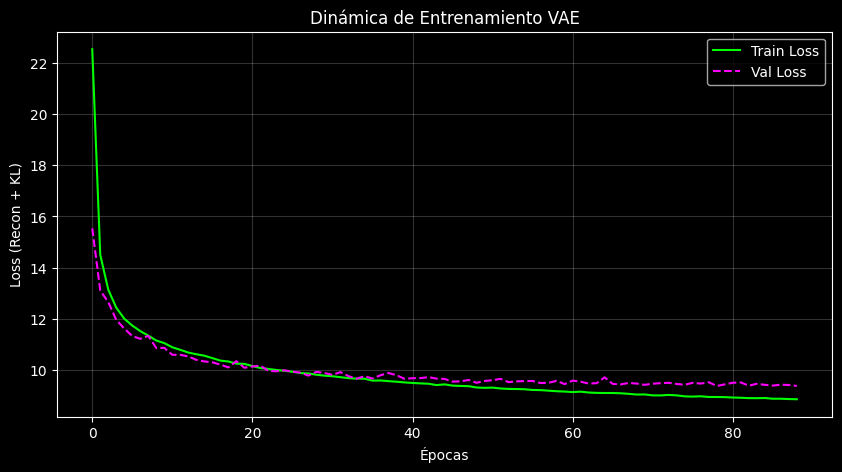


[INFO] Generando proyecciones del espacio latente...


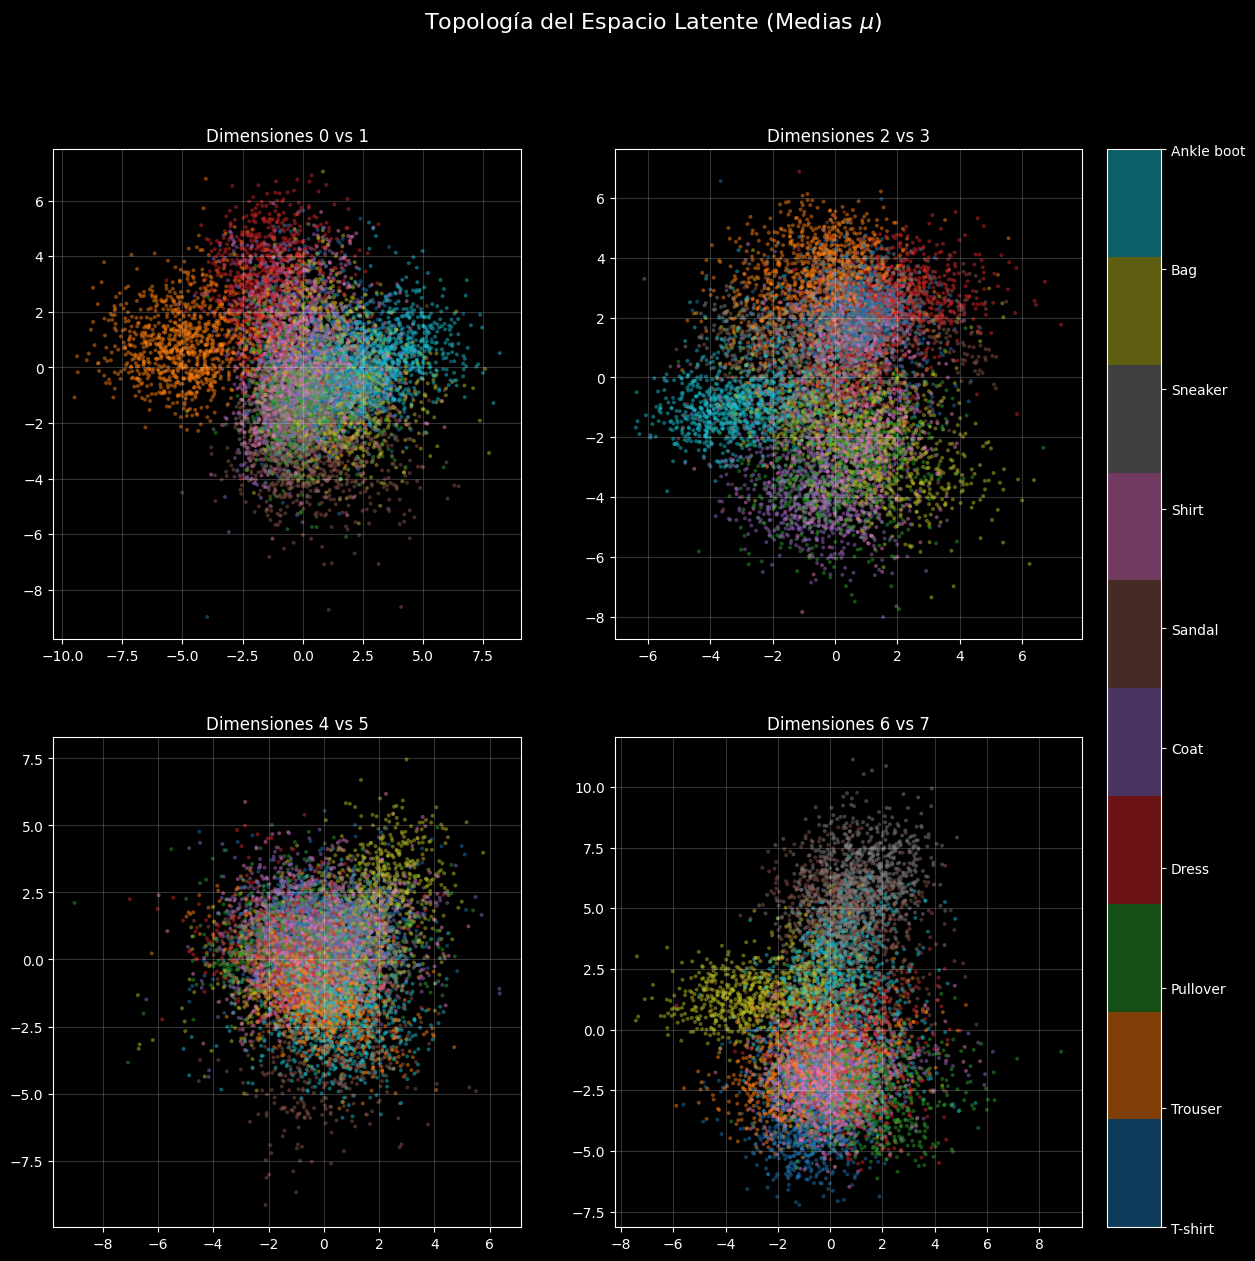


[INFO] Calculando proyección t-SNE ...


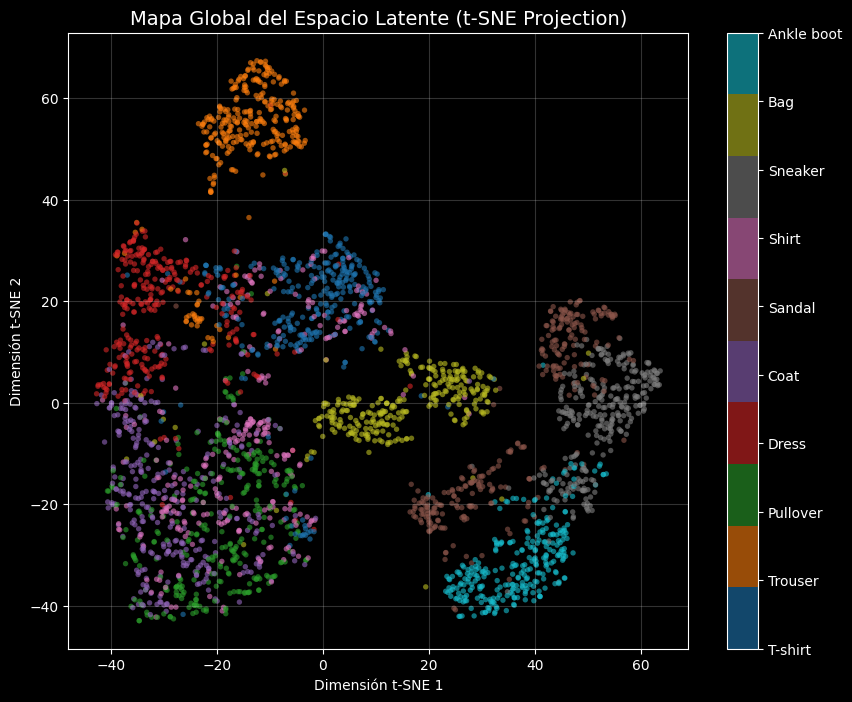

Generando interpolación de Sandalia a Bota...


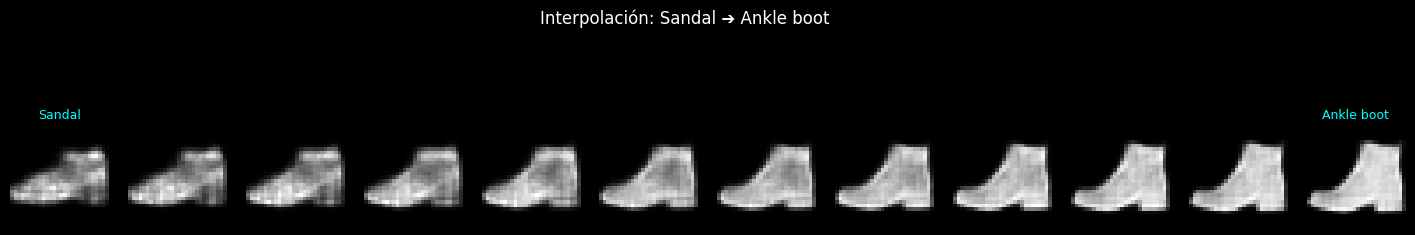

Generando interpolación de Pantalón a Vestido...


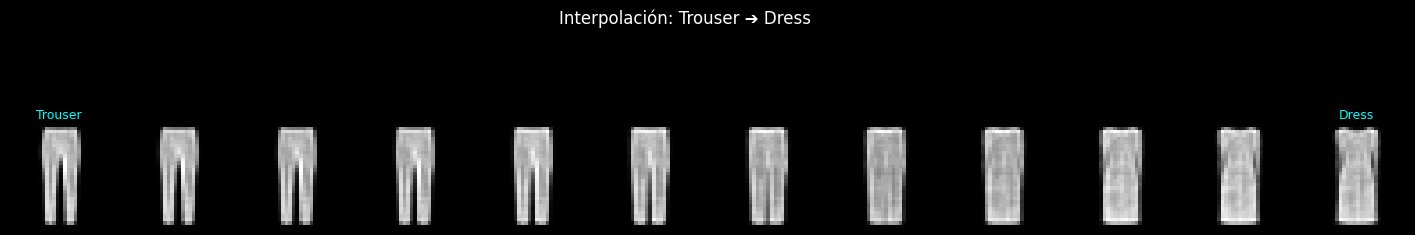

In [6]:
class GenerativeAuditor:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    def plot_curves(self, t_loss, v_loss):
        plt.figure(figsize=(10, 5))
        plt.plot(t_loss, label='Train Loss', color='#00ff00')
        plt.plot(v_loss, label='Val Loss', color='#ff00ff', linestyle='--')
        plt.title("Dinámica de Entrenamiento VAE")
        plt.xlabel("Épocas")
        plt.ylabel("Loss (Recon + KL)")
        plt.legend()
        plt.show()

    def plot_tsne_map(self, loader):
        """
        Genera una proyección t-SNE del espacio latente completo (8D -> 2D)
        """
        self.model.eval()
        latents, labels = [], []

        # 1. Extraer todos los vectores latentes
        print("\n[INFO] Calculando proyección t-SNE ...")
        with torch.no_grad():
            for imgs, lbls in loader:
                _, mu, _ = self.model(imgs)
                latents.append(mu.cpu().numpy())
                labels.append(lbls.cpu().numpy())

        latents = np.concatenate(latents, axis=0)
        labels = np.concatenate(labels, axis=0)

        # 2. Ejecutar t-SNE (Reducción de 8D a 2D)
        # Tomamos un subset de 3000 puntos para que sea rápido y no sature la gráfica
        limit = 3000
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        latents_2d = tsne.fit_transform(latents[:limit])
        labels_subset = labels[:limit]

        # 3. Visualizar
        plt.figure(figsize=(10, 8))
        cmap = plt.get_cmap('tab10', 10)
        scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1],
                              c=labels_subset, cmap=cmap, alpha=0.6, s=15, edgecolors='none')

        cbar = plt.colorbar(scatter, ticks=range(10))
        cbar.set_ticklabels(self.classes)
        plt.title("Mapa Global del Espacio Latente (t-SNE Projection)", fontsize=14)
        plt.xlabel("Dimensión t-SNE 1")
        plt.ylabel("Dimensión t-SNE 2")
        plt.show()

    def map_latent_topology(self, loader):
        """ Proyecta los vectores mu de 8D en 4 gráficos 2D """
        self.model.eval()
        latents, labels = [], []

        with torch.no_grad():
            for imgs, lbls in loader:
                _, mu, _ = self.model(imgs)
                latents.append(mu.cpu().numpy())
                labels.append(lbls.cpu().numpy())

        latents = np.concatenate(latents, axis=0)
        labels = np.concatenate(labels, axis=0)

        fig, axes = plt.subplots(2, 2, figsize=(16, 14))
        axes = axes.flatten()
        cmap = plt.get_cmap('tab10', 10)

        print("\n[INFO] Generando proyecciones del espacio latente...")
        for i in range(4):
            ax = axes[i]
            dim_x, dim_y = i*2, i*2 + 1
            scatter = ax.scatter(latents[:, dim_x], latents[:, dim_y],
                                 c=labels, cmap=cmap, alpha=0.5, s=8, edgecolors='none')
            ax.set_title(f'Dimensiones {dim_x} vs {dim_y}', color='white')

        cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), pad=0.02)
        cbar.set_ticks(range(10))
        cbar.set_ticklabels(self.classes)
        plt.suptitle(r"Topología del Espacio Latente (Medias $\mu$)", fontsize=16)
        plt.show()

        return latents, labels

    def generate_prototypical_morphing(self, latents, labels, class_a, class_b, steps=12):
        """
        Interpolación entre los vectores promedio (prototipos) de dos clases.
        """
        # 1. Calcular Centroides
        proto_a = latents[labels == class_a].mean(axis=0)
        proto_b = latents[labels == class_b].mean(axis=0)

        # 2. Generar trayectoria lineal en espacio latente
        vectors = []
        for t in np.linspace(0, 1, steps):
            v = (1 - t) * proto_a + t * proto_b
            vectors.append(v)

        z_input = torch.tensor(np.array(vectors)).float().to(self.device)

        # 3. Decodificar
        self.model.eval()
        with torch.no_grad():
            generated = self.model.decoder_body(z_input)
            generated = generated.view(steps, 28, 28).cpu().numpy()

        # 4. Visualizar Tira
        plt.figure(figsize=(18, 3))
        for i in range(steps):
            ax = plt.subplot(1, steps, i + 1)
            plt.imshow(generated[i], cmap='gray')
            plt.axis('off')
            if i == 0: ax.set_title(self.classes[class_a], color='cyan', fontsize=9)
            if i == steps - 1: ax.set_title(self.classes[class_b], color='cyan', fontsize=9)

        plt.suptitle(f"Interpolación: {self.classes[class_a]} ➔ {self.classes[class_b]}", y=1.05)
        plt.show()

# Instanciar Auditor
auditor = GenerativeAuditor(model, DEVICE)
auditor.plot_curves(loss_t, loss_v)

# 1. Visualizar Espacio Latente y obtener datos
latents_test, labels_test = auditor.map_latent_topology(test_loader)

# Visualización con t-SNE
auditor.plot_tsne_map(test_loader)

# 2. Generar Interpolaciones (Morphing)
print("Generando interpolación de Sandalia a Bota...")
auditor.generate_prototypical_morphing(latents_test, labels_test, 5, 9) # Sandal -> Boot

print("Generando interpolación de Pantalón a Vestido...")
auditor.generate_prototypical_morphing(latents_test, labels_test, 1, 3) # Trouser -> Dress